# Taylor Rule Analysis

This notebook calculates the Taylor Rule and compares it with the actual Federal Funds Rate.

The Taylor Rule is defined as:
r = p + 0.5y + 0.5(p - 2) + 2

Where:
- r is the federal funds rate
- p is the rate of inflation
- y is the percent deviation of real GDP from target
- 2 is the target inflation rate

In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.api.fred_client import FREDClient
from src.models.economic_data import Series
from src.utils.helpers import series_to_dataframe

%matplotlib inline
plt.style.use('classic')

In [2]:
# Initialize FRED client
client = FREDClient()

# Fetch required data series
series_ids = {
    'GDPC1': 'Real GDP',                # Real GDP
    'GDPPOT': 'Potential GDP',          # Potential GDP
    'PCEPI': 'PCE Price Index',         # PCE Price Index
    'FEDFUNDS': 'Federal Funds Rate'    # Federal Funds Rate
}

# Fetch data and convert to dataframes
dfs = {}
for series_id, name in series_ids.items():
    data = client.get_series(series_id)
    series = Series.from_api_response(data)
    dfs[series_id] = series_to_dataframe(series)

In [3]:
def calculate_output_gap(gdp_df, potential_gdp_df):
    """Calculate the output gap as percentage deviation from potential GDP."""
    return ((gdp_df['value'] - potential_gdp_df['value']) / potential_gdp_df['value']) * 100

def calculate_inflation_rate(pce_df):
    """Calculate year-over-year inflation rate from PCE index."""
    return pce_df['value'].pct_change(periods=12) * 100

def calculate_taylor_rule(inflation_rate, output_gap):
    """Calculate the Taylor Rule recommended rate."""
    target_inflation = 2.0
    return inflation_rate + 0.5 * output_gap + 0.5 * (inflation_rate - target_inflation) + 2

In [4]:
# Calculate components
output_gap = calculate_output_gap(dfs['GDPC1'], dfs['GDPPOT'])
inflation_rate = calculate_inflation_rate(dfs['PCEPI'])

# Create a combined dataframe
analysis_df = pd.DataFrame({
    'output_gap': output_gap,
    'inflation_rate': inflation_rate,
    'actual_rate': dfs['FEDFUNDS']['value']
}).dropna()

# Calculate Taylor Rule
analysis_df['taylor_rule'] = calculate_taylor_rule(
    analysis_df['inflation_rate'],
    analysis_df['output_gap']
)

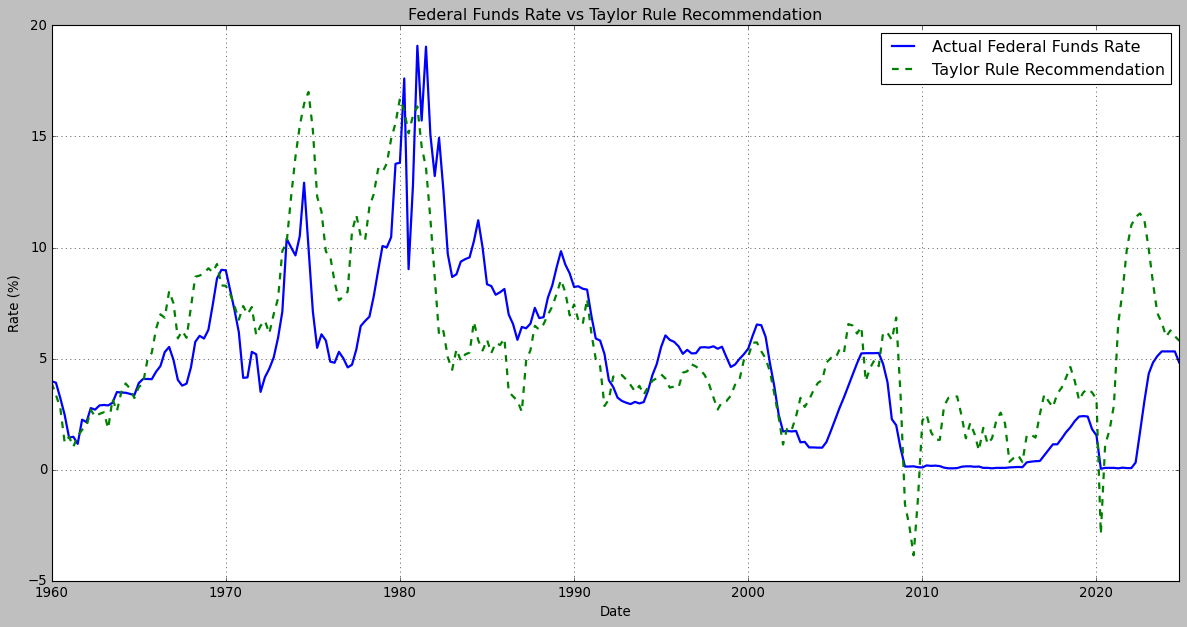

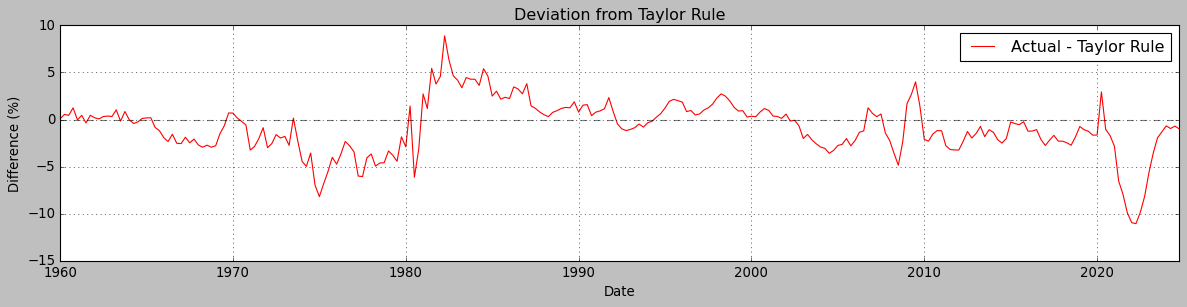

In [5]:
# Plot the results
plt.figure(figsize=(15, 8))

# Plot actual and Taylor Rule rates
plt.plot(analysis_df.index, analysis_df['actual_rate'], 
         label='Actual Federal Funds Rate', linewidth=2)
plt.plot(analysis_df.index, analysis_df['taylor_rule'], 
         label='Taylor Rule Recommendation', linewidth=2, linestyle='--')

plt.title('Federal Funds Rate vs Taylor Rule Recommendation')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the difference
plt.figure(figsize=(15, 4))
difference = analysis_df['actual_rate'] - analysis_df['taylor_rule']
plt.plot(analysis_df.index, difference, color='red', 
         label='Actual - Taylor Rule')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Deviation from Taylor Rule')
plt.xlabel('Date')
plt.ylabel('Difference (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Calculate summary statistics
recent_data = analysis_df.last('5Y')  # Last 5 years of data

print("Recent Taylor Rule Analysis (Last 5 Years):")
print(f"Average actual rate: {recent_data['actual_rate'].mean():.2f}%")
print(f"Average Taylor rule rate: {recent_data['taylor_rule'].mean():.2f}%")
print(f"Average deviation: {(recent_data['actual_rate'] - recent_data['taylor_rule']).mean():.2f}%")
print(f"\nComponents:")
print(f"Average inflation rate: {recent_data['inflation_rate'].mean():.2f}%")
print(f"Average output gap: {recent_data['output_gap'].mean():.2f}%")

Recent Taylor Rule Analysis (Last 5 Years):
Average actual rate: 2.39%
Average Taylor rule rate: 6.60%
Average deviation: -4.21%

Components:
Average inflation rate: 3.60%
Average output gap: 0.39%


/var/folders/vc/jv93x1gn4_g6y91blkt96h280000gn/T/ipykernel_5692/2564183292.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_data = analysis_df.last('5Y')  # Last 5 years of data
/var/folders/vc/jv93x1gn4_g6y91blkt96h280000gn/T/ipykernel_5692/2564183292.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  recent_data = analysis_df.last('5Y')  # Last 5 years of data
